In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from numpy.linalg import multi_dot, inv
%matplotlib inline

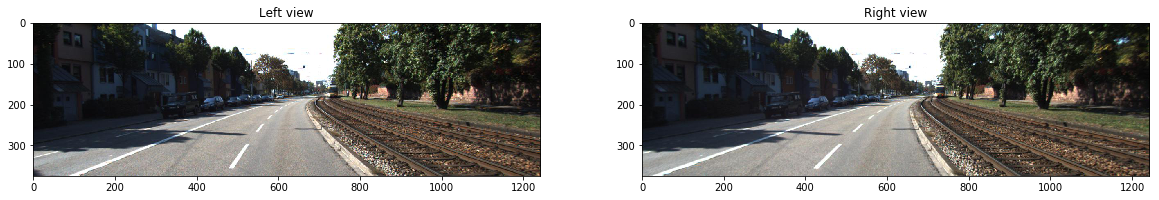

In [2]:
left_view = mpimg.imread('/home/szuyu/workspace/mergedepth/data/left_imgs/2011_09_26_drive_0001_sync/0000000000.jpg')
right_view = mpimg.imread('/home/szuyu/workspace/mergedepth/data/right_imgs/2011_09_26_drive_0001_sync/0000000000.jpg')
#Sample depth map output from another repo
ref = mpimg.imread('/home/szuyu/workspace/semodepth/encode/2011_09_26_drive_0001/0000000000.jpg', 0)
#01,05,15,19,35
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.set_title('Left view')
ax1.imshow(left_view)
ax2.set_title('Right view')
ax2.imshow(right_view)
plt.show()

69.9162821652854 5.534028758489626e-05


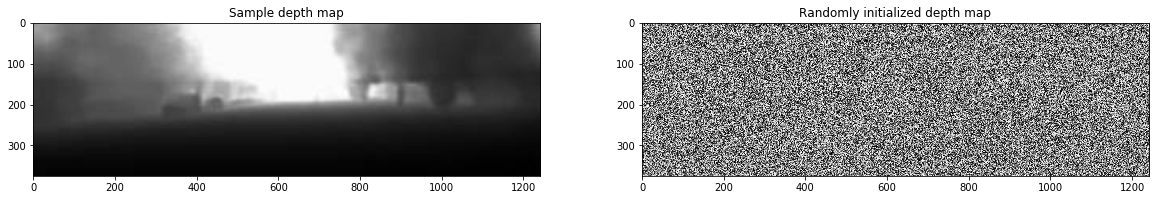

In [3]:
ref = ref / 3 #reverse previous enhancement
ref = cv2.resize(ref, (left_view.shape[1], left_view.shape[0]))
rd = np.dot(np.random.rand(ref.shape[0], ref.shape[1]), np.amax(ref))
#rd = np.random.rand(ref.shape[0], ref.shape[1])
print(np.amax(rd), np.amin(rd))

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.imshow(ref, cmap='gray')
ax1.set_title("Sample depth map")
ax2.imshow(rd, 'gray')
ax2.set_title("Randomly initialized depth map")
plt.show()

## Warping Function
$p_{3} = K_{3}R_{3}K_{2}^{-1}Z_{w}p_{2}-K_{3}R_{3}C_{3}$ <br/>
http://www.epixea.com/research/multi-view-coding-thesisch4.html <br/>

Annotations: <br/>
- 2: Original scene (left), 3: Warped / synthesized scene (target right)
- $p_{2}$: Source pixel position on original scene ($\mathbb{R}^{2}$)
- $p_{3}$: Warped pixel position on synthesized scene ($\mathbb{R}^{2}$)
- $Z_{w}$: Depth of point in real scene (Point $P_{w} = (X_{w}, Y_{w}, Z_{w})^{T} \in \mathbb{R}^{3}$)
- $K_{2}, K_{3}$: Intrinsic parameters ($\mathbb{R}_{3x3}$)
- $R_{3}$: Rotation matrix (related to camera position 1) ($\mathbb{R}_{3x3}$)
- $C_{3}$: Camera center potision (related to camera position 1) ($\mathbb{R}^{3}$)

https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT <br/>
The color and grayscale cameras are mounted close to each other (~6 cm), the baseline of both stereo rigs is approximately 54 cm. <br/>
The opening angle of the cameras (left-right) is approximately 90 degrees.

In [ ]:
class Reconstruction():
    def __init__(self, date):
        self.date = date
        self.K2R2_K3 = None
        self.K3R3C3 = None
        self.K3R3_K2 = None
        self.K2R2C2 = None
        
        self._get_transformations()
        
    def _get_transformations(self):
        if self.date=='2011_09_26':
            self.K2 = np.array([[9.597910e+02, 0.000000e+00, 6.960217e+02],
                               [0.000000e+00, 9.569251e+02, 2.241806e+02],
                               [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.K3 = np.array([[9.037596e+02, 0.000000e+00, 6.957519e+02],
                               [0.000000e+00, 9.019653e+02, 2.242509e+02],
                               [0.000000e+00, 0.000000e+00,1.000000e+00]])
            self.R2 = np.array([[ 9.999758e-01, -5.267463e-03, -4.552439e-03],
                                [ 5.251945e-03,  9.999804e-01, -3.413835e-03],
                                [ 4.570332e-03,  3.389843e-03,  9.999838e-01]])
            self.t2 = np.array([[ 5.956621e-02],
                                [ 2.900141e-04],
                                [ 2.577209e-03]])
            self.R3 = np.array([[ 9.995599e-01,  1.699522e-02, -2.431313e-02],
                                [-1.704422e-02,  9.998531e-01, -1.809756e-03],
                                [ 2.427880e-02,  2.223358e-03,  9.997028e-01]])
            self.t3 = np.array([[-4.731050e-01], 
                                [ 5.551470e-03],
                                [-5.250882e-03]])
  
        elif self.date=='2011_09_28':
            self.K2 = np.array([[9.569475e+02, 0.000000e+00, 6.939767e+02],
                                [0.000000e+00, 9.522352e+02, 2.386081e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.K3 = np.array([[9.011007e+02, 0.000000e+00, 6.982947e+02],
                                [0.000000e+00, 8.970639e+02, 2.377447e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.R2 = np.array([[ 9.999838e-01, -5.012736e-03, -2.710741e-03],
                                [ 5.002007e-03,  9.999797e-01, -3.950381e-03],
                                [ 2.730489e-03,  3.936758e-03,  9.999885e-01]])
            self.t2 = np.array([[ 5.989688e-02],
                                [-1.367835e-03],
                                [ 4.637624e-03]])
            self.R3 = np.array([[ 9.995054e-01,  1.665288e-02, -2.667675e-02],
                                [-1.671777e-02,  9.998578e-01, -2.211228e-03],
                                [ 2.663614e-02,  2.656110e-03,  9.996417e-01]])
            self.t3 = np.array([[-4.756270e-01],
                                [ 5.296617e-03],
                                [-5.437198e-03]])
        
        elif self.date=='2011_09_29':
            self.K2 = np.array([[9.607501e+02, 0.000000e+00, 6.944288e+02],
                                [0.000000e+00, 9.570051e+02, 2.363374e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.K3 = np.array([[9.047872e+02, 0.000000e+00, 6.946163e+02], 
                                [0.000000e+00, 9.017079e+02, 2.353088e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.R2 = np.array([[ 9.999807e-01, -5.053665e-03, -3.619905e-03],
                                [ 5.036396e-03,  9.999760e-01, -4.764072e-03],
                                [ 3.643894e-03,  4.745749e-03,  9.999821e-01]])
            self.t2 = np.array([[ 5.948968e-02], 
                                [-8.603063e-04], 
                                [ 2.662728e-03]])
            self.R3 = np.array([[ 9.995851e-01,  1.666283e-02, -2.349366e-02],
                                [-1.674297e-02,  9.998546e-01, -3.218496e-03],
                                [ 2.343662e-02,  3.610514e-03,  9.997188e-01]])
            self.t3 = np.array([[-4.732167e-01],
                                [ 5.830806e-03],
                                [-4.405247e-03]])
            
        elif self.date=='2011_09_30':
            self.K2 = np.array([[9.591977e+02, 0.000000e+00, 6.944383e+02],
                                [0.000000e+00, 9.529324e+02, 2.416793e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.K3 = np.array([[9.035972e+02, 0.000000e+00, 6.979803e+02],
                                [0.000000e+00, 8.979356e+02, 2.392935e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.R2 = np.array([[ 9.999805e-01, -4.971067e-03, -3.793081e-03],
                                [ 4.954076e-03,  9.999777e-01, -4.475856e-03],
                                [ 3.815246e-03,  4.456977e-03,  9.999828e-01]])
            self.t2 = np.array([[ 6.030222e-02],
                                [-1.293125e-03],
                                [ 5.900421e-03]])
            self.R3 = np.array([[ 9.994995e-01,  1.667420e-02, -2.688514e-02],
                                [-1.673122e-02,  9.998582e-01, -1.897204e-03],
                                [ 2.684969e-02,  2.346075e-03,  9.996367e-01]])
            self.t3 = np.array([[-4.747879e-01],
                                [ 5.631988e-03],
                                [-5.233709e-03]])
            
        elif self.date=='2011_10_03':
            self.K2 = np.array([[9.601149e+02, 0.000000e+00, 6.947923e+02],
                                [0.000000e+00, 9.548911e+02, 2.403547e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.K3 = np.array([[9.049931e+02, 0.000000e+00, 6.957698e+02],
                                [0.000000e+00, 9.004945e+02, 2.389820e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.R2 = np.array([[ 9.999788e-01, -5.008404e-03, -4.151018e-03],
                                [ 4.990516e-03,  9.999783e-01, -4.308488e-03],
                                [ 4.172506e-03,  4.287682e-03,  9.999821e-01]])
            self.t2 = np.array([[ 5.954406e-02], 
                                [-7.675338e-04], 
                                [ 3.582565e-03]])
            self.R3 = np.array([[ 9.995578e-01,  1.656369e-02, -2.469315e-02],
                                [-1.663353e-02,  9.998582e-01, -2.625576e-03],
                                [ 2.464616e-02,  3.035149e-03,  9.996916e-01]])
            self.t3 = np.array([[-4.738786e-01],
                                [ 5.991982e-03],
                                [-3.215069e-03]])

        #L2R
        dR = np.eye(3) #No rotation
        self.K3R3_K2 = multi_dot([self.K3, dR, inv(self.K2)])
        self.K3R3C3 = multi_dot([self.K3, dR, (self.t2 - self.t3)])

        #R2L
        self.K2R2_K3 = multi_dot([self.K2, dR, inv(self.K3)])
        self.K2R2C2 = multi_dot([self.K2, dR, (self.t3 - self.t2)])
            
    def _remap(self, p2, Zw, direction):
        if direction == 'L2R':
            p3 = np.dot(self.K3R3_K2, Zw*p2) - self.K3R3C3
            return [int(p3[0] / p3[2]), int(p3[1] / p3[2])]
        elif direction == 'R2L':
            p3 = np.dot(self.K2R2_K3, Zw*p2) - self.K2R2C2
            return [int(p3[0] / p3[2]), int(p3[1] / p3[2])]

    def _reconstruct(self, depth_map, src_image, direction):
        
        canvas = np.zeros_like(src_image, dtype=np.uint8)
        if np.amax(src_image) <= 1.0:
            src_image = np.dot(src_image, 255).astype(int)
            
        for x in range(src_image.shape[1]): #width
            for y in range(src_image.shape[0]):
                p3_x, p3_y = self._remap(p2=np.array([[x], [y], [1]]), 
                                         Zw = depth_map[y][x], direction=direction)
                if(0 <= p3_x < src_image.shape[1] and 0 <= p3_y < src_image.shape[0]):
                    canvas[p3_y][p3_x] = src_image[y][x]

        return canvas
    
    def _recon_loss(self, tar, syn):
        loss = 0
        pt = 0
        
        if np.amax(tar)<=1.0: 
            tar = (np.dot(tar,255)) #Normalize [0.0, 1.0] --> [0, 255]
            
        tar = tar.astype(float)
        syn = syn.astype(float)
        
        dev = np.multiply((tar - syn), tar.astype(bool)) / 255
        loss = np.sum(np.multiply(dev, dev))/ np.sum(tar.astype(bool))
        #dev = (tar - syn) / 255
        #loss = np.sum(np.multiply(dev, dev)) / (tar.shape[0]*tar.shape[1])

        return round(loss, 4)
    
    #Public function
    def compute_loss(self, depth_map, src_image, tar_image, direction):
        
        syn_image = self._reconstruct(depth_map=depth_map, src_image=src_image, direction=direction)
        loss = self._recon_loss(tar=tar_image, syn=syn_image)
        return loss, syn_image

In [ ]:
recon = [Reconstruction(date='2011_09_26'), Reconstruction(date='2011_09_28'),
         Reconstruction(date='2011_09_29'), Reconstruction(date='2011_09_30'),
         Reconstruction(date='2011_10_03')]

In [ ]:
loss1, synthesized1 = recon[0].compute_loss(ref, left_view, right_view, 'L2R')
loss2, synthesized2 = recon[0].compute_loss(rd, left_view, right_view, 'L2R')
print(loss1, loss2) #1381.1503 2374.9963

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (18,12))
ax1.set_title('Right view')
ax1.imshow(right_view)
ax2.set_title('Good synthesized')
ax2.imshow(synthesized1)
ax3.set_title('Poor synthesized')
ax3.imshow(synthesized2)
plt.show()

In [4]:
from src.loss_beta import *
recon_import = [Reconstruction(date='2011_09_26'), Reconstruction(date='2011_09_28'),
                Reconstruction(date='2011_09_29'), Reconstruction(date='2011_09_30'),
                Reconstruction(date='2011_10_03')]

In [5]:
loss1, synthesized1 = recon_import[0].compute_loss(ref, left_view, right_view, 'L2R')
loss2, synthesized2 = recon_import[0].compute_loss(rd, left_view, right_view, 'L2R')
print(loss1, loss2) #4146.5639 7078.1797 #1381.1503 2378.0211

0.124361 0.307172


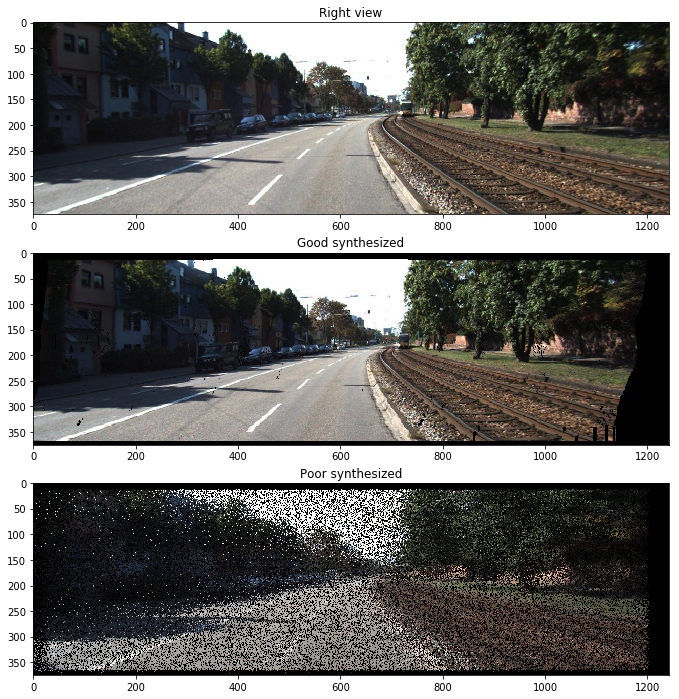

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (18,12))
ax1.set_title('Right view')
ax1.imshow(right_view)
ax2.set_title('Good synthesized')
ax2.imshow(synthesized1)
ax3.set_title('Poor synthesized')
ax3.imshow(synthesized2)
plt.show()